In [1]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
#run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
#sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
# %cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
# run=33 #1/32 degree NeverWorld setup
# fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
# os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
# forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
# #av = xr.open_dataset('run%i/averages_00002002.nc' % (run), decode_times=False)  #5-day average

# av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
# print(av)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

In [4]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']

xh = fs.xh.values
yh = fs.yh.values

taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(560, 240)

In [14]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.tile(drho,[len(yh),len(xh),1]);    drhomat =np.moveaxis(drhomat, [0, 1, 2], [1,2,0])


v = (np.array(av['v'][-1,:,:,:])); v=(v[:,:-1,:]+v[:,1:,:])/2; #v=v[:,index_lat,index_lon]
u = (np.array(av['u'][-1,:,:,:])); u=(u[:,:,:-1]+u[:,:,1:])/2; 
Rd_dx= np.array(av['Rd_dx'][-1,:,:])

h = np.array(av['h'][-1,:,:,:]);
eta = np.zeros([len(Layer)+1,lon.shape[0],lon.shape[1]]);

for i in range(1,len(Layer)+1):
    eta[i,:,:]=np.nansum(h[0:i,:,:],axis=0)    
#To make sure eta is correct: #print(eta[:,50]); print(h[:,50])    
eta=(eta[1:,:,:]+eta[:-1,:,:])/2.
drhodz=drhomat/h
N2=(9.81/1025.)*drhodz

#Filter out overly high N2 values (corresponding to very thin layers)
u[N2>1.e-3] =np.nan
v[N2>1.e-3] =np.nan
eta[N2>1.e-3] =np.nan
N2[N2>1.e-3] =np.nan

print(u.shape)
print(Rd_dx.shape)

(15, 560, 240)
(560, 240)


In [84]:
len(xh)

240

In [104]:
from scipy.io import loadmat
ds1  = loadmat('Quarter_deg_QG_modes.mat')
lon = ds1['lon']
lat = ds1['lat']
KE  = ds1['KE for each mode']
KE_vertical=np.nansum(KE,axis=0)
KE_vertical.shape
ds2  = loadmat('quarterdeg_planview.mat')
k_kd_small = ds2['wavenumber_max']
lon_small  = ds2['Lon']
lat_small  = ds2['Lat']

k_kd = np.empty([560,240]); k_kd[:]=np.nan
for i in range(1,26):
    for j in range(1,66):
        k_kd[16+(j-1)*8:16+j*8,16+(i-1)*8:16+i*8] = k_kd_small[i,j]
    print(i)
k_kd[200:360]=np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [86]:
fraction_BT=KE[0,:,:]/KE_vertical
fraction_BC1=KE[1,:,:]/KE_vertical
fraction_BCtot=np.nansum(KE[1:,:,:]/KE_vertical,axis=0)
print(Rd_dx.shape)
print(np.nanmin(fraction_BT+fraction_BCtot))

(560, 240)
0.9999999999999993


Text(0, 0.5, 'Barotropic fraction')

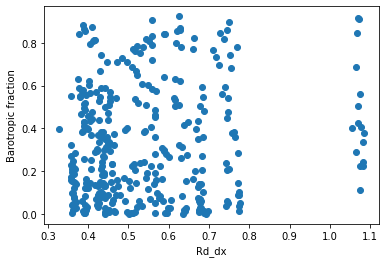

In [111]:
plt.plot(Rd_dx[:,200]/k_kd[:,200],fraction_BT[:,200], 'o')
plt.xlabel('Rd_dx')
plt.ylabel('Barotropic fraction')

In [93]:
(Rd_dx[:,:]/k_kd[:,:]).shape

(560, 240)

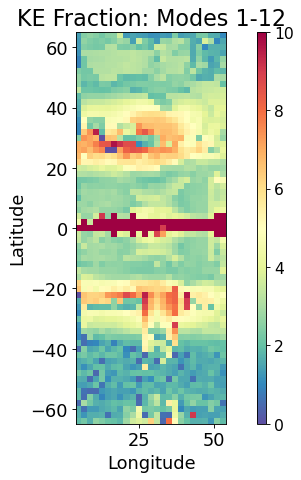

In [81]:
#Plotting Fraction of all baroclinic modes
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('KE Fraction: Modes 1-12',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(lon_small[0,:],lat_small[0,:],np.transpose(k_kd_small),cmap=cm.Spectral_r,vmin=0,vmax=10)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

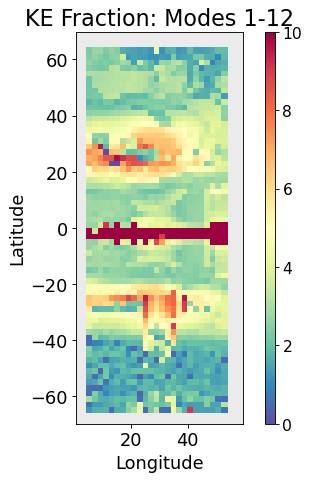

In [83]:
#Plotting Fraction of all baroclinic modes
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('KE Fraction: Modes 1-12',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(lon,lat,(k_kd),cmap=cm.Spectral_r,vmin=0,vmax=10)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

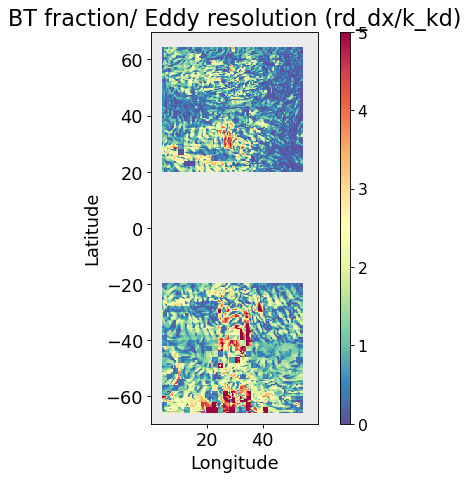

In [105]:
#Plotting Fraction of all baroclinic modes
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('BT fraction/ Eddy resolution (rd_dx/k_kd)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(lon,lat,fraction_BT/(Rd_dx[:,:]/k_kd[:,:]),cmap=cm.Spectral_r,vmin=0,vmax=5)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()